## Notebook 05 – Bootstrap Validation

This notebook performs boostrap validation of long vs short momentum returns conditioned on volatility and dispersion regimes. The bootstrap function returns mean difference, lower and upper confidence intervals, as well as p-value for the differences.

### Step 0 - Import packages and functions

In [2]:
import sys, os
sys.path.append(os.path.abspath("../src"))
import pandas as pd
import numpy as np

# Helper functions for bootstrap validation
from stats_helpers import bootstrap_ci, bootstrap_mean_diff
from report_helpers import format_diff_result, format_ci_result
from plot_helpers import plot_ci_bar

C:\Users\edzz0\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


### Step 1 - Import long-short returns by low vs high volatility and dispersion regimes.

In [3]:
# Three threshold methods
methods = ["static", "rolling", "expanding"]

# Create dict for different regime type labels between volatility and dispersion
regime_type_to_labels = {
    "vol": ["low_vol", "high_vol"],
    "disp": ["low_disp", "high_disp"],
}

# Create dict to store results
wf_mom_returns = {}

# iterate through and import parquet files
for regime_type, regime_labels in regime_type_to_labels.items():
    for method in methods:
        for regime_label in regime_labels:
            key = f"{regime_label}_{method}"  # e.g. "low_vol_static"
            path = f"../data/processed/wf_mom_{key}.parquet"
            col_name = f"wf_mom_{regime_label}"
            wf_mom_returns[key] = pd.read_parquet(path)[col_name]

### Step 2 - Conduct bootstrap validation on long-short returns by regime

In [4]:
# Create dict to store bootstrapped confidence intervals
ci_results = {}

# Create dict to store bootstrapped difference in means results
diff_results = {}

# Three threshold methods
methods = ["static", "rolling", "expanding"]
regime_type_to_labels = {
    "vol": ["low_vol", "high_vol"],
    "disp": ["low_disp", "high_disp"],
}

# Iterate through and run bootstrap testing
for regime_type, labels in regime_type_to_labels.items():
    for method in methods:
        low_key = f"{labels[0]}_{method}"   # e.g. "low_vol_static"
        high_key = f"{labels[1]}_{method}"  # e.g. "high_vol_static"
        diff_key = f"{regime_type}_{method}"

        ci_low = bootstrap_ci(wf_mom_returns[low_key], seed = 0)
        ci_high = bootstrap_ci(wf_mom_returns[high_key], seed = 0)
        ci_results[low_key] = ci_low
        ci_results[high_key] = ci_high

        diff_result = bootstrap_mean_diff(wf_mom_returns[low_key], wf_mom_returns[high_key], seed = 0)
        diff_results[diff_key] = diff_result

        # Helper function to print bootstrapped confidence interval results
        format_ci_result(low_key, ci_low)
        format_ci_result(high_key, ci_high)

        # Helper function to print bootstrapped difference in means results
        format_diff_result(diff_key, diff_result)

Regime: low_vol_static
Mean: 0.000337
95% CI: [-0.000229, 0.000885]
--------------------------------------------------
Regime: high_vol_static
Mean: -0.000374
95% CI: [-0.001560, 0.000742]
--------------------------------------------------
Comparison: vol_static
Group 1 (Low Vol) — Mean: 0.000337, N: 1131
Group 2 (High Vol) — Mean: -0.000374, N: 999
Mean Difference: 0.000711
Boostrap Difference: -0.000015
95% CI for Difference: [-0.001285, 0.001212]
P-value: 0.274
--------------------------------------------------
Regime: low_vol_rolling
Mean: 0.000258
95% CI: [-0.000361, 0.000858]
--------------------------------------------------
Regime: high_vol_rolling
Mean: 0.000269
95% CI: [-0.000747, 0.001344]
--------------------------------------------------
Comparison: vol_rolling
Group 1 (Low Vol) — Mean: 0.000258, N: 1280
Group 2 (High Vol) — Mean: 0.000269, N: 938
Mean Difference: -0.000012
Boostrap Difference: -0.000017
95% CI for Difference: [-0.001145, 0.001163]
P-value: 0.989
---------

# Step 4 - Plot and Export Barplots with confidence intervals

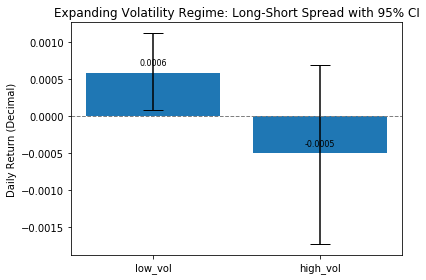

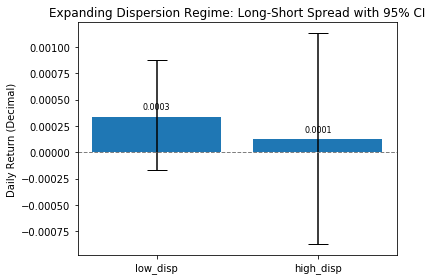

In [5]:
# Isolate expanding quantile definition, the one of focus for this project due to temporal integrity and label stability
# Loop through volatility and dispersion
for prefix, plot_title, filename, order in [
    ("vol", "Expanding Volatility Regime: Long-Short Spread with 95% CI", "expanding_regime_bar.png", ["low_vol", "high_vol"]),
    ("disp", "Expanding Dispersion Regime: Long-Short Spread with 95% CI", "expanding_disp_regime_bar.png", ["low_disp", "high_disp"])
]:
    
    low_key = f"low_{prefix}_expanding"
    high_key = f"high_{prefix}_expanding"

    # Low regime confidence interval
    ci_low = bootstrap_ci(wf_mom_returns[low_key], seed = 0)
    
    # High regime confidence interval
    ci_high = bootstrap_ci(wf_mom_returns[high_key], seed = 0)

    # Store confidence interval results
    expanding_results = {
        order[0]: ci_low,
        order[1]: ci_high
    }

    # Helper function to plot and export
    plot_ci_bar(
        expanding_results,
        title=plot_title,
        filename=filename,
        order=order
    )